This notebook creates a small cube of data for testing interactions with the tracking corrections. Segmentation was performed previously but ultrack is run here on the small cube (not subsetted from the general solution).

In [49]:
import napari
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.measure import regionprops_table   
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

from tifffile import imwrite

### Get the data

In [44]:
im1_path = r'D:\kasia\tracking\E6_exp\E6_C0.zarr'
im2_path = r'D:\\Kasia\tracking\E6_exp\E6_C1.zarr'

segmentation_path = r'D:\kasia\tracking\E6_exp\segmentation'

save_path = r'D:\kasia\tracking\E6_exp\sample_data'

t_min = 100
t_max = 120
r_min = 10000
r_max =11000
c_min = 10000
c_max = 11000

In [45]:
# get channel 1 data
reader = Reader(parse_url(im1_path))
image_node = list(reader())[0]
dask_data = image_node.data

ch1 = dask_data[0][t_min:t_max, r_min:r_max, c_min:c_max].compute()
imwrite(save_path + r'\ch1.tif', ch1)

In [46]:
# get channel 2 data
reader = Reader(parse_url(im2_path))
image_node = list(reader())[0]
dask_data = image_node.data

ch2 = dask_data[0][t_min:t_max, r_min:r_max, c_min:c_max].compute()
imwrite(save_path + r'\ch2.tif', ch2)

In [39]:
# get segmentation data
seg_list = []
for i in range(t_min, t_max):
    seg = imread(segmentation_path + f'\mask_{str(i).zfill(3)}.png')
    seg = seg[r_min:r_max, c_min:c_max]
    seg_list.append(seg)

seg = np.array(seg_list)

c:\Users\kmk280\.conda\envs\tracking\lib\site-packages\imageio\plugins\pillow.py:312: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


In [47]:
imwrite(save_path + r'\seg.tif', seg)

In [60]:
viewer = napari.Viewer()
viewer.add_image(ch1,colormap='green',blending='additive')
viewer.add_image(ch2,colormap='red',blending='additive')
viewer.add_labels(seg, name='segmentation',blending='additive')

c:\Users\kmk280\.conda\envs\tracking\lib\site-packages\napari\_qt\qt_main_window.py:543: UserWarning: Using NAPARI_PERFMON with an already-running QtApp (--gui qt?) is not supported.
  qapp = get_app()


<Labels layer 'segmentation' at 0x151784994b0>

### Measure properties

In [58]:
properties=('label', 'centroid', 'area','image','mean_intensity')
df_list = []
for i in range(t_max-t_min):
    intensity_image=np.array([ch1[i],ch2[i]])
    intensity_image = np.moveaxis(intensity_image, 0, -1)
    data = regionprops_table(seg[i], properties=properties, intensity_image=intensity_image)
    df = pd.DataFrame(data)
    df['frame'] = i
    df_list.append(df)

df = pd.concat(df_list)
df.to_csv(save_path + r'\segmentation.csv', index=False)

### Tracking

In [69]:
from ultrack.utils import estimate_parameters_from_labels, labels_to_edges
from ultrack.config import MainConfig
from ultrack import track, to_tracks_layer, tracks_to_zarr

In [62]:
detection, edges = labels_to_edges(seg, sigma=4.0)

Converting labels to edges: 100%|██████████| 20/20 [00:00<00:00, 22.84it/s]


In [63]:
viewer.add_image(edges, blending="additive", colormap="magma")

<Image layer 'edges' at 0x1517a32a4d0>

In [65]:
config = MainConfig()

Estimating params.: 100%|██████████| 20/20 [00:00<00:00, 85.29it/s]


<Axes: title={'center': 'Area histogram'}, ylabel='Frequency'>

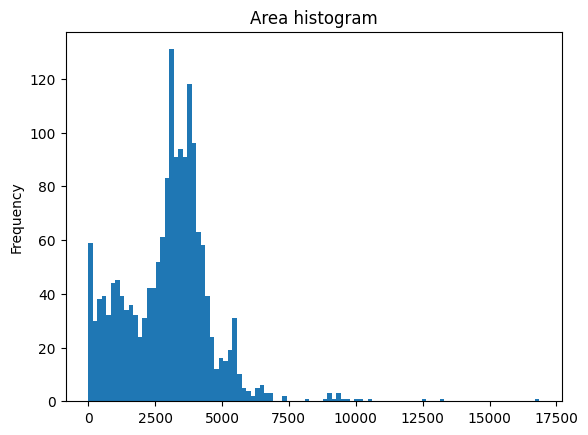

In [66]:
params_df = estimate_parameters_from_labels(seg, is_timelapse=True)
params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

In [68]:
config.segmentation_config.min_area = 1000
config.segmentation_config.max_area = 5000
config.segmentation_config.n_workers = 8

config.linking_config.max_distance = 50
config.linking_config.n_workers = 10

config.tracking_config.appear_weight = -1
config.tracking_config.disappear_weight = -0.5
config.tracking_config.division_weight = -0.1
config.tracking_config.power = 4
config.tracking_config.bias = -0.001
config.tracking_config.solution_gap = 0.0

In [70]:
track(
    detection=detection,
    edges=edges,
    config=config,
    overwrite=True,
)

Linking nodes.: 100%|██████████| 19/19 [00:11<00:00,  1.70it/s]


Using CBC solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Saving solution ...
Done!


In [71]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)

c:\Users\kmk280\.conda\envs\tracking\lib\site-packages\numba\typed\typeddict.py:39: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  return d[key]
Exporting segmentation masks: 100%|██████████| 20/20 [00:00<00:00, 93.24it/s]


In [72]:
viewer.add_labels(labels)

<Labels layer 'labels' at 0x1517c5a1690>

In [73]:
imwrite(save_path + r'\track_labels.tif', labels)